<!-- docusaurus_head_meta::start
---
title: Introduction Notebook
---
docusaurus_head_meta::end -->

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{intro-colab} -->

# Implement Your Reseach RAG with Live Interent Data

Integrating Web Data with LLMs Using Weave for Tracking and Evaluation!

This notebook demonstrates how to integrate a Large Language Model (LLM) that fetches web-based data into your application while leveraging Weave to track, evaluate, and debug the process. We'll be using Weave to log inputs and outputs, evaluate model responses, and analyze where performance can be improved.

Stack Used:



*   LlamaIndex workflows for orchestration
*   Tavily API as the search engine api
*   Other LlamaIndex abstractions like VectorStoreIndex, PostProcessors etc.


See the full Weave documentation [here](https://wandb.me/weave).


"""
# Architecture for LLM and Web Data Integration Using Weave
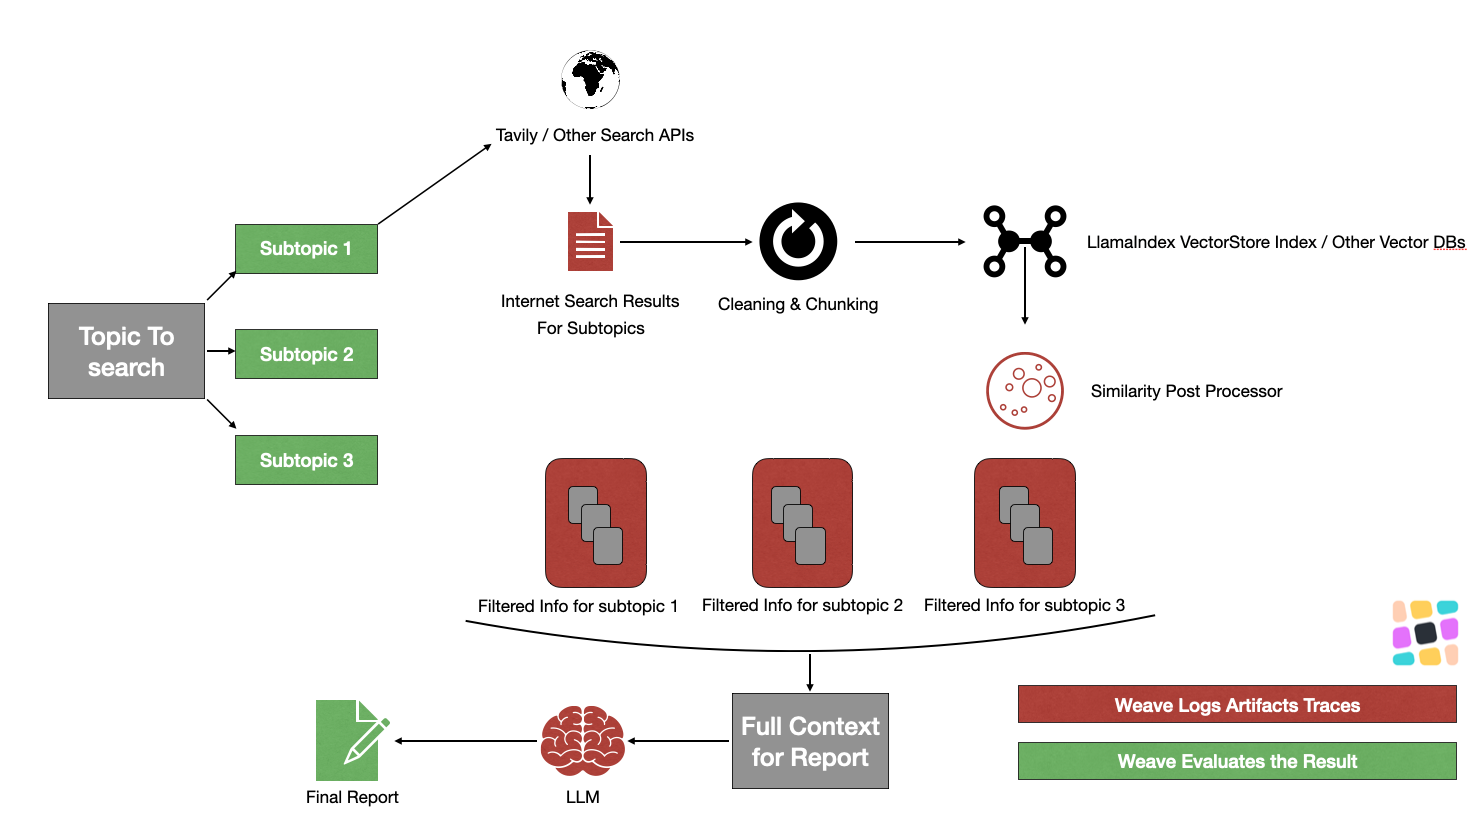
1. **Topic to Search → Subtopics**
   - **Input**: The main topic is broken down into smaller, more specific **subtopics** for focused queries.
   - **Goal**: These subtopics help narrow down the search scope, allowing for more targeted and relevant results.

2. **Search API Call (Tavily or Other Search APIs)**
   - **Search Process**: Each subtopic is sent to an internet search API like **Tavily** to retrieve relevant content.
   - **Flexibility**: Any web search API can be used here (Tavily is just an example, but alternatives like Google or Bing can be applied).

3. **Internet Search Results for Subtopics**
   - **Result**: The API fetches web data relevant to each subtopic, providing content like links, snippets, and raw text.
   - **Output**: The raw data collected from the web.

4. **Cleaning and Chunking**
   - **Process**: The raw data is cleaned and split into smaller chunks to make it easier to process.
   - **Purpose**: Prepares the data for embedding into a vector database, ensuring it's in a structured and usable format.

5. **LlamaIndex VectorStore Index / Other Vector DBs**
   - **Storage**: The processed data is indexed in **LlamaIndex's VectorStore** or another vector database.
   - **Function**: This allows for efficient semantic search and retrieval of documents based on their similarity to the query.

6. **Similarity Post-Processor**
   - **Filtering**: The search results are filtered based on their **similarity** to the query to ensure high relevance.
   - **Objective**: Only the most useful information is passed to the LLM for further processing.

7. **Filtered Info for Subtopics**
   - **Result**: The relevant, filtered information for each subtopic is ready for LLM integration.
   - **Purpose**: These are the cleaned and processed results from the web, categorized by subtopic.

8. **LLM Context Creation**
   - **Context**: The filtered information from all subtopics is compiled into a **full context** for the LLM.
   - **Goal**: To provide the LLM with rich, relevant data from multiple sources for generating accurate and insightful responses.

9. **LLM Processing**
   - **LLM Task**: The LLM takes the context and generates the **final report** or response based on the collected web data.
   - **Role**: It synthesizes the gathered information into a coherent output, such as a summary or detailed report.

10. **Weave for Logging and Evaluation**
   - **Logging**: **Weave** logs all steps of the process, including inputs, outputs, and any encountered errors, allowing for easy debugging.
   - **Evaluation**: Weave is also used to **evaluate** the LLM’s performance by tracking metrics such as accuracy and relevance.
   - **Traceability**: Weave provides full traceability, making it easier to reproduce or debug the workflow.
"""



## 🪄 Install dependencies and `weave` library to login




In [ ]:
%%capture
!pip install weave \
openai set-env-colab-kaggle-dotenv \
llama-index-core==0.11.11 \
llama-index-embeddings-openai==0.2.5 \
llama-index-llms-openai==0.2.9 \
llama-index-utils-workflow==0.2.1 \
llama-parse==0.5.6 \
markdown_pdf==1.3 \
requests \
python-dotenv==1.0.1


In [ ]:
# Set your OpenAI API key

# Put your OPENAI_API_KEY in the secrets panel to the left 🗝️
_ = set_env("OPENAI_API_KEY")
# os.environ["OPENAI_API_KEY"] = "sk-..." # alternatively, put your key here

PROJECT = "Live-Internet-RAG"
from set_env import set_env


# How Weave Helps here?

Weave allows users to track function calls: the code, inputs, outputs, and even LLM tokens & costs! In the following sections we will cover:

### 1. **Track and Log Inputs and Outputs**:
Weave allows you to log the web data inputs fed into the LLM and the corresponding LLM outputs in real time. This provides full visibility over the data flow through the model.

### 2. **Evaluation of Model Performance**:
You can evaluate the quality of LLM responses to web data by using Weave to store and visualize evaluation scores (e.g., relevance of LLM responses, accuracy against expected results).

### 3. **Compare Experiments Easily**:
Weave can help you run multiple experiments with different web data sources or LLM configurations. It allows you to compare performance metrics across different runs, helping to identify the best model configurations for given tasks.

### 4. **Detailed Debugging**:
Weave's automatic input/output logging allows for detailed debugging. If the LLM produces unexpected or erroneous outputs (e.g., hallucinations or incorrect responses), you can trace back through the logs to understand where the issue occurred.

### 5. **Model Behavior Insight**:
Using Weave's tools, you can drill down into failure modes (e.g., where the LLM did not correctly interpret web data) and gain insights into how model behavior changes based on different inputs.

### 6. **Visualization of Key Metrics**:
Weave provides interactive dashboards to visualize important metrics such as model loss, evaluation scores, and response quality over time. These visualizations help monitor the performance and stability of the integrated solution.

### 7. **Reproducibility**:
Weave makes it easy to reproduce experiments by logging all the details related to each run, such as input data, LLM versions, and hyperparameters, ensuring all experiment steps are stored for future reference.

### 8. **Seamless Integration with ML Pipelines**:
Since Weave integrates directly with Weights & Biases (W&B), it can be embedded seamlessly into MLOps workflows, allowing for continuous tracking and optimization of LLMs interacting with web data in production environments.


Note: in all cases, we will:

```python
import weave                    # import the weave library
weave.init('project-name')      # initialize tracking for a specific W&B project
```


## Steps
This code defines a function that uses the Tavily Search API to retrieve documents based on a provided query. It sends the query to the API, retrieves relevant results (such as web page content and metadata), and processes those results into a list of Document objects that contain the content and metadata (like source URL and title). The function also ensures that URLs are not revisited during the search process by using a set of visited URLs.

Note: Tavily is used as an example here, and you can replace it with any other search API by adjusting the request structure accordingly.

Note: Add the @weave.op decorator to the functions you want to track which here we want to track this function input and output:

In [ ]:
weave.init(PROJECT)
import weave


Please login to Weights & Biases (https://wandb.ai/) to continue:


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Logged in as Weights & Biases user: mg01.
View Weave data at https://wandb.ai/wandb-smle/live-internet-rag/weave


1. **Topic to Search → Subtopics**
   - **Input**: The main topic is broken down into smaller, more specific **subtopics** for focused queries.
   - **Goal**: These subtopics help narrow down the search scope, allowing for more targeted and relevant results.

With Weave, We are tracking this function, all its input and output for further investigation and later evluations


In [ ]:

# Load environment variables
load_dotenv()

# Define the sub-query prompt template
SUB_QUERY_PROMPT = PromptTemplate(
    'Write {max_iterations} google search queries to search online that form an objective opinion from the following task: "{task}"\n'
    f"Assume the current date is {datetime.now(timezone.utc).strftime('%B %d, %Y')} if required.\n"
    f"You must respond with the search queries separated by comma in the following format: query 1, query 2, query 3\n"
    "{max_iterations} google search queries for {task} (separated by comma): "
)



@weave.op()
async def SubQueryGenerator(query: str, llm: LLM, num_sub_queries: int = 3) -> List[str]:
    """
    Gets the sub queries
    Args:
        query: original query
        llm: LLM to generate sub queries
        num_sub_queries: number of sub-queries to generate (default 3)
    Returns:
        sub_queries: List of sub queries
    """
    # Await the response as `apredict` is asynchronous
    response = await llm.apredict(
        SUB_QUERY_PROMPT,
        task=query,
        max_iterations=num_sub_queries,
    )

    # Clean and split the response into sub-queries
    sub_queries = list(
        map(lambda x: x.strip().strip('"').strip("'"), response.split(","))
    )

    return sub_queries



2. **Search API Call (Tavily or Other Search APIs)**
   - **Search Process**: Each subtopic is sent to an internet search API like **Tavily** to retrieve relevant content.
   - **Flexibility**: Any web search API can be used here (Tavily is just an example, but alternatives like Google or Bing can be applied).


3. **Internet Search Results for Subtopics**
   - **Result**: The API fetches web data relevant to each subtopic, providing content like links, snippets, and raw text.
   - **Output**: The raw data collected from the web.

Here we also tracking all internet search results utilzing Weave in this fuction so we can further assess what resources and contents from web are coming to our application


In [ ]:

import requests

@weave.op()

async def get_docs_from_tavily_search(sub_query: str, visited_urls: set[str]):
    load_dotenv()
    # Put your TAVILY_API_KEY in the secrets panel to the left 🗝️
    _ = set_env("TAVILY_API_KEY")
    api_key = os.getenv("TAVILY_API_KEY")
    base_url = "https://api.tavily.com/search"
    headers = {
        "Content-Type": "application/json",
    }
    data = {
        "query": sub_query,
        "api_key": api_key,
        "include_raw_content": True,
    }

    docs = []
    print(f"\n> Searching Tavily for sub query: {sub_query}\n")
    response = requests.post(base_url, headers=headers, json=data)
    if response.status_code == 200:
        search_results = response.json().get("results", [])
        for search_result in search_results:
            url = search_result.get("url")
            if not search_result.get("raw_content"):
                continue
            if url not in visited_urls:
                visited_urls.add(url)
                docs.append(
                    Document(
                        text=search_result.get("raw_content"),
                        metadata={
                            "source": url,
                            "title": search_result.get("title"),
                        },
                    )
                )
        print(f"\n> Found {len(docs)} docs from Tavily search on {sub_query}\n")
        return docs, visited_urls
    else:
        response.raise_for_status()



In the next cell:

4. **Cleaning and Chunking**
   - **Process**: The raw data is cleaned and split into smaller chunks to make it easier to process.
   - **Purpose**: Prepares the data for embedding into a vector database, ensuring it's in a structured and usable format.

5. **LlamaIndex VectorStore Index / Other Vector DBs**
   - **Storage**: The processed data is indexed in **LlamaIndex's VectorStore** or another vector database.
   - **Function**: This allows for efficient semantic search and retrieval of documents based on their similarity to the query.

6. **Similarity Post-Processor**
   - **Filtering**: The search results are filtered based on their **similarity** to the query to ensure high relevance.
   - **Objective**: Only the most useful information is passed to the LLM for further processing.

7. **Filtered Info for Subtopics**
   - **Result**: The relevant, filtered information for each subtopic is ready for LLM integration.
   - **Purpose**: These are the cleaned and processed results from the web, categorized by subtopic.

8. **LLM Context Creation**
   - **Context**: The filtered information from all subtopics is compiled into a **full context** for the LLM.
   - **Goal**: To provide the LLM with rich, relevant data from multiple sources for generating accurate and insightful responses.

Here we are also tracking all raw internet docuemnts from search results  embdeding model and filterested results by similarity search with Weave:

In [ ]:
from typing import List
from llama_index.core.schema import Document
from llama_index.core.embeddings import BaseEmbedding
from llama_index.core.text_splitter import SentenceSplitter
from llama_index.core import VectorStoreIndex
from llama_index.core.postprocessor import SimilarityPostprocessor


@weave.op()
async def get_compressed_context(
    query: str, docs: List[Document], embed_model: BaseEmbedding
) -> str:
    index = VectorStoreIndex.from_documents(
        docs,
        embed_model=embed_model,
        transformations=[SentenceSplitter()],
    )

    retriever = index.as_retriever(similarity_top_k=100)

    nodes = retriever.retrieve(query)

    processor = SimilarityPostprocessor(similarity_cutoff=0.38)
    filtered_nodes = processor.postprocess_nodes(nodes)
    # print(filtered_nodes)
    print(
        f"\n> Filtered {len(filtered_nodes)} nodes from {len(nodes)} nodes for subquery: {query}\n"
    )

    context = ""

    for node_with_score in filtered_nodes:
        node = node_with_score.node
        node_info = (
            f"---\nSource: {node.metadata.get('source', 'Unknown')}\n"
            f"Title: {node.metadata.get('title', '')}\n"
            f"Content: {node.text}\n---\n"
        )
        context += node_info + "\n"

    return context

9. **LLM Processing**
   - **LLM Task**: The LLM takes the context and generates the **final report** or response based on the collected web data.
   - **Role**: It synthesizes the gathered information into a coherent output, such as a summary or detailed report.


We are publishing the prompt used as object in weave so can be used ror re-utilization, assessment of the effectiveness of the prompt and tracability:

In [ ]:
from datetime import datetime, timezone
from llama_index.core.llms.llm import LLM
from llama_index.core.prompts.base import PromptTemplate


# Define a class that extends weave.Object to store the prompt
# Define and publish the ReportPrompt class
class ReportPrompt(weave.Object):
    prompt: str

# Create an instance of ReportPrompt with your prompt string
report_prompt = ReportPrompt(
    prompt="""Information:
--------------------------------
{context}
--------------------------------
Using the above information, answer the following query or task: "{question}" in a detailed report --
The report should focus on the answer to the query, should be well structured, informative,
in-depth, and comprehensive, with facts and numbers if available and at least {total_words} words.
You should strive to write the report as long as you can using all relevant and necessary information provided.

Please follow all of the following guidelines in your report:
- You MUST determine your own concrete and valid opinion based on the given information. Do NOT defer to general and meaningless conclusions.
- You MUST write the report with markdown syntax and {report_format} format.
- You MUST prioritize the relevance, reliability, and significance of the sources you use. Choose trusted sources over less reliable ones.
- You must also prioritize new articles over older articles if the source can be trusted.
- Use in-text citation references in {report_format} format and make it with markdown hyperlink placed at the end of the sentence or paragraph that references them like this: ([in-text citation](url)).
- Don't forget to add a reference list at the end of the report in {report_format} format and full url links without hyperlinks.
- You MUST write all used source urls at the end of the report as references, and make sure to not add duplicated sources, but only one reference for each.
Every url should be hyperlinked: [url website](url)
Additionally, you MUST include hyperlinks to the relevant URLs wherever they are referenced in the report:

e.g., Author, A. A. (Year, Month Date). Title of web page. Website Name. [url website](url)

Assume that the current date is {date_today}.
"""
)

# Even though we're not retrieving the prompt from Weave, we can still publish it
weave.publish(report_prompt)

# Modify the generate_report_from_context function to use the prompt directly
@weave.op()
async def generate_report_from_context(query: str, context: str, llm: LLM) -> str:
    prompt = PromptTemplate(report_prompt.prompt)
    response = await llm.apredict(
        prompt,
        context=context,
        question=query,
        total_words=1000,
        report_format="APA",
        date_today=datetime.now(timezone.utc).strftime("%B %d, %Y"),
    )
    print("\n> Done generating report\n")
    return response


📦 Published to https://wandb.ai/wandb-smle/live-internet-rag/weave/objects/ReportPrompt/versions/57xHixMYyits4iaExXuFqUhgXYC5fXI4nZ7I2RKukSI


# End to End Pipeline with LlamaIndex

Here we are caling all steps defined previously to create our workflow:

In [ ]:
from typing import List, Any
from llama_index.core.schema import Document
from llama_index.core.embeddings import BaseEmbedding
from llama_index.core.llms.llm import LLM
from llama_index.core.workflow import (
    step,
    Context,
    Workflow,
    Event,
    StartEvent,
    StopEvent,
)
from markdown_pdf import MarkdownPdf, Section


class SubQueriesCreatedEvent(Event):
    sub_queries: List[str]


class ToProcessSubQueryEvent(Event):
    sub_query: str


class DocsScrapedEvent(Event):
    sub_query: str
    docs: List[Document]


class ToCombineContextEvent(Event):
    sub_query: str
    context: str


class ReportPromptCreatedEvent(Event):
    context: str


class LLMResponseEvent(Event):
    response: str


class ResearchAssistantWorkflow(Workflow):
    def __init__(
        self,
        *args: Any,
        llm: LLM,
        embed_model: BaseEmbedding,
        **kwargs: Any,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.llm = llm
        self.embed_model = embed_model
        self.visited_urls: set[str] = set()

    @step
    async def create_sub_queries(self, ctx: Context, ev: StartEvent) -> SubQueriesCreatedEvent:
      query = ev.query
      await ctx.set("query", query)
      #generator = SubQueryGenerator
      sub_queries = await SubQueryGenerator(query=query, llm=self.llm)
      await ctx.set("num_sub_queries", len(sub_queries))
      return SubQueriesCreatedEvent(sub_queries=sub_queries)

    @step
    async def deligate_sub_queries(
        self, ctx: Context, ev: SubQueriesCreatedEvent
    ) -> ToProcessSubQueryEvent:
        for sub_query in ev.sub_queries:
            ctx.send_event(ToProcessSubQueryEvent(sub_query=sub_query))
        return None

    @step
    async def get_docs_for_subquery(
        self, ev: ToProcessSubQueryEvent
    ) -> DocsScrapedEvent:
        sub_query = ev.sub_query
        docs, visited_urls = await get_docs_from_tavily_search(
            sub_query, self.visited_urls
        )
        self.visited_urls = visited_urls
        return DocsScrapedEvent(sub_query=sub_query, docs=docs)

    @step(num_workers=3)
    async def compress_docs(self, ev: DocsScrapedEvent) -> ToCombineContextEvent:
        sub_query = ev.sub_query
        docs = ev.docs
        print(f"\n> Compressing docs for sub query: {sub_query}\n")
        compressed_context = await get_compressed_context(
            sub_query, docs, self.embed_model
        )
        return ToCombineContextEvent(sub_query=sub_query, context=compressed_context)

    @step
    async def combine_contexts(
        self, ctx: Context, ev: ToCombineContextEvent
    ) -> ReportPromptCreatedEvent:
        events = ctx.collect_events(
            ev, [ToCombineContextEvent] * await ctx.get("num_sub_queries")
        )
        if events is None:
            return None

        context = ""

        for event in events:
            context += (
                f'Research findings for topic "{event.sub_query}":\n{event.context}\n\n'
            )

        return ReportPromptCreatedEvent(context=context)

    @step

    async def write_report(
        self, ctx: Context, ev: ReportPromptCreatedEvent
    ) -> StopEvent:
        context = ev.context
        query = await ctx.get("query")
        print(f"\n> Writing report. This will take a few minutes...\n")

        # Directly use the prompt from the report_prompt object
        report = await generate_report_from_context(query, context, self.llm)

        pdf = MarkdownPdf()
        pdf.add_section(Section(report, toc=False))
        pdf.save("report.pdf")
        print("\n> Done writing report to report.pdf! Trying to open the file...\n")
        return StopEvent(result=report)

Here we are creating our pipeline as end to end model registered in weave so whole pipeline can be re-utlized and being used down the road for end to end evaluation with Weave:

In [ ]:
import asyncio
import nest_asyncio
from dotenv import load_dotenv
from google.colab import files  # To download the report file from Colab
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

load_dotenv()

# Apply nest_asyncio to allow nested event loops in Colab
nest_asyncio.apply()


class generate_report_class(weave.Model):
  model: str = "gpt-4o-mini"
  embedding: str = "text-embedding-3-small"

  # Define the async function
  @weave.op()
  async def predict(self,topic: str) -> str :
      # Initialize LLM and embedding model
      llm = OpenAI(model=self.model)
      embed_model = OpenAIEmbedding(model=self.embedding)

      # Initialize the workflow
      workflow = ResearchAssistantWorkflow(
          llm=llm, embed_model=embed_model, verbose=True, timeout=440.0
      )

      # Run the workflow with the given topic
      report_file = await workflow.run(query=topic)  # Await the async function

      # Provide download link for the generated report file
      #files.download(report_file)
      #print(f"Report generated: {report_file}")
      return report_file


Sample test for running the pipeline, this should give you saved pdf report of your reseach results:

In [ ]:

# Wrapper function to run the async function in Colab
def generate_report(topic: str):
  pipeline = generate_report_class()
    # Directly await the workflow execution in Colab's running event loop
  return asyncio.run(pipeline.predict(topic))

In [ ]:
# Example of how to use the function in a Colab cell
# You can modify the `topic` string to any topic you want
topic="How Weave from Weights and Biases support LLMOps"
generate_report(topic)


Running step create_sub_queries
Step create_sub_queries produced event SubQueriesCreatedEvent
Running step deligate_sub_queries
Step deligate_sub_queries produced no event
Running step get_docs_for_subquery

> Searching Tavily for sub query: How Weave from Weights and Biases enhances LLMOps


> Found 5 docs from Tavily search on How Weave from Weights and Biases enhances LLMOps

Step get_docs_for_subquery produced event DocsScrapedEvent
Running step get_docs_for_subquery

> Searching Tavily for sub query: Weights and Biases Weave features for LLMOps support


> Found 3 docs from Tavily search on Weights and Biases Weave features for LLMOps support

Step get_docs_for_subquery produced event DocsScrapedEvent
Running step get_docs_for_subquery

> Searching Tavily for sub query: Benefits of using Weave for LLMOps in machine learning projects


> Found 4 docs from Tavily search on Benefits of using Weave for LLMOps in machine learning projects

Step get_docs_for_subquery produced event Docs

"# How Weave from Weights and Biases Supports LLMOps\n\n## Introduction\n\nThe rapid evolution of Large Language Models (LLMs) has transformed the landscape of artificial intelligence (AI) and natural language processing (NLP). As organizations increasingly adopt LLMs for various applications, the need for effective operational management has become paramount. This is where Large Language Model Operations (LLMOps) comes into play, providing a structured framework for managing the lifecycle of LLMs. Among the tools available to facilitate LLMOps, Weights and Biases (W&B) Weave stands out as a powerful solution that enhances the efficiency, collaboration, and effectiveness of LLM development and deployment. This report delves into how Weave supports LLMOps, highlighting its features, benefits, and practical applications.\n\n## Understanding LLMOps\n\nLLMOps encompasses a set of practices and tools designed to streamline the deployment, management, and monitoring of LLMs. It integrates pr

# Evaluation

Evaluation-driven development helps you reliably iterate on an application. The `Evaluation` class is designed to assess the performance of a `Model` on a given `Dataset` or set of examples using scoring functions.

See a preview of the API below:

To assess the quality of our report generation tool for research, we'll implement  evaluation metrics:

In [ ]:
import json
from openai import OpenAI
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage

@weave.op()
def evaluate_report(
    report_summary: str, topic: str, model: str = "gpt-4o"
) -> dict:
    prompt = f"""
    Report Summary: {report_summary}
    Research Topic Query: {topic}

    Evaluate the summary based on the following criteria:
    1. Relevance (1-5): How well does the report address the given search query?
    2. Conciseness (1-5): How concise is the report while retaining key information questioned in research query?
    3. report Structure (1-5): How properly the whole report is structured to cover all information details in proper formatting?

    Your response MUST be in the following JSON format:
    {{
        "relevance": {{
            "score": <int>,
            "explanation": "<string>"
        }},
        "conciseness": {{
            "score": <int>,
            "explanation": "<string>"
        }},
        "report_structure": {{
            "score": <int>,
            "explanation": "<string>"
        }}
    }}

    Ensure that the scores are integers between 1 and 5, and that the explanations are concise.
    """

    messages = [
        ChatMessage(
            role="system", content="You are an evaluator for the given research report"
        ),
        ChatMessage(role="user", content=prompt),
    ]

    # Get response from the OpenAI model
    try:
        response = str(OpenAI(model=model).chat(messages))

        # Debug: Print or log the entire response for checking format
        print("Response from model:", response)

        # Try to find the JSON section in the response
        start = response.find('{')
        end = response.rfind('}') + 1

        if start == -1 or end == -1:
            raise ValueError("Invalid JSON response format")

        json_string = response[start:end]
        eval_dict = json.loads(json_string)

        return {
            "relevance": eval_dict["relevance"]["score"],
            "conciseness": eval_dict["conciseness"]["score"],
            "report_structure": eval_dict["report_structure"]["score"],
            "average_score": sum(eval_dict[k]["score"] for k in eval_dict) / 3,
            "evaluation_text": response,
        }

    except json.JSONDecodeError as e:
        print(f"JSON decoding failed: {e}")
        return {"error": "Failed to parse evaluation response"}
    except Exception as e:
        print(f"An error occurred: {e}")
        return {"error": str(e)}


To evaluate our pipeline, we'll create a Weave Dataset and run an evaluation:

In [ ]:
 #Create a Weave Dataset
dataset = weave.Dataset(
    name="Web_Powered_RAG_Eval_Data",
    rows=[
        {
            "topic": "How Weights and Biases can help with MLOps? "
        },
    ],
)

weave.publish(dataset)

📦 Published to https://wandb.ai/wandb-smle/live-internet-rag/weave/objects/Web_Powered_RAG_Eval_Data/versions/8I6TOSGX0ICPIEOP0ECPS9ZkAuZ60xOQrCrE17CSnO0


ObjectRef(entity='wandb-smle', project='live-internet-rag', name='Web_Powered_RAG_Eval_Data', digest='8I6TOSGX0ICPIEOP0ECPS9ZkAuZ60xOQrCrE17CSnO0', extra=())

In [ ]:
# Define the scorer function
@weave.op()
def quality_scorer(topic: str, model_output: str) -> dict:
    result = evaluate_report(model_output, topic)
    return result

For our evaluation, we'll use an LLM-as-a-judge approach. This technique involves using a language model to assess the quality of outputs generated by another model or system. It leverages the LLM's understanding and reasoning capabilities to provide nuanced evaluations, especially for tasks where traditional metrics may fall short.

In [ ]:
# Run evaluation
evaluation = weave.Evaluation(dataset=dataset, scorers=[quality_scorer])
pipeline = generate_report_class()
results = await evaluation.evaluate(pipeline)

Running step create_sub_queries
Step create_sub_queries produced event SubQueriesCreatedEvent
Running step deligate_sub_queries
Step deligate_sub_queries produced no event
Running step get_docs_for_subquery

> Searching Tavily for sub query: How Weights and Biases improves MLOps efficiency


> Found 5 docs from Tavily search on How Weights and Biases improves MLOps efficiency

Step get_docs_for_subquery produced event DocsScrapedEvent
Running step get_docs_for_subquery

> Searching Tavily for sub query: Benefits of using Weights and Biases for machine learning operations


> Found 4 docs from Tavily search on Benefits of using Weights and Biases for machine learning operations

Step get_docs_for_subquery produced event DocsScrapedEvent
Running step get_docs_for_subquery

> Searching Tavily for sub query: Weights and Biases features for MLOps best practices


> Found 3 docs from Tavily search on Weights and Biases features for MLOps best practices

Step get_docs_for_subquery produced ev

Evaluated 1 of 1 examples

Evaluation summary
{
    'quality_scorer': {
        'report_structure': {'mean': 5.0},
        'relevance': {'mean': 5.0},
        'average_score': {'mean': 4.666666666666667},
        'conciseness': {'mean': 4.0}
    },
    'model_latency': {'mean': 49.12239742279053}
}

🍩 https://wandb.ai/wandb-smle/live-internet-rag/r/call/019254be-fc9e-7c82-b4d8-7cb7abc6d930


You can find your interactive dashboard by clicking any of the  👆 wandb links above.

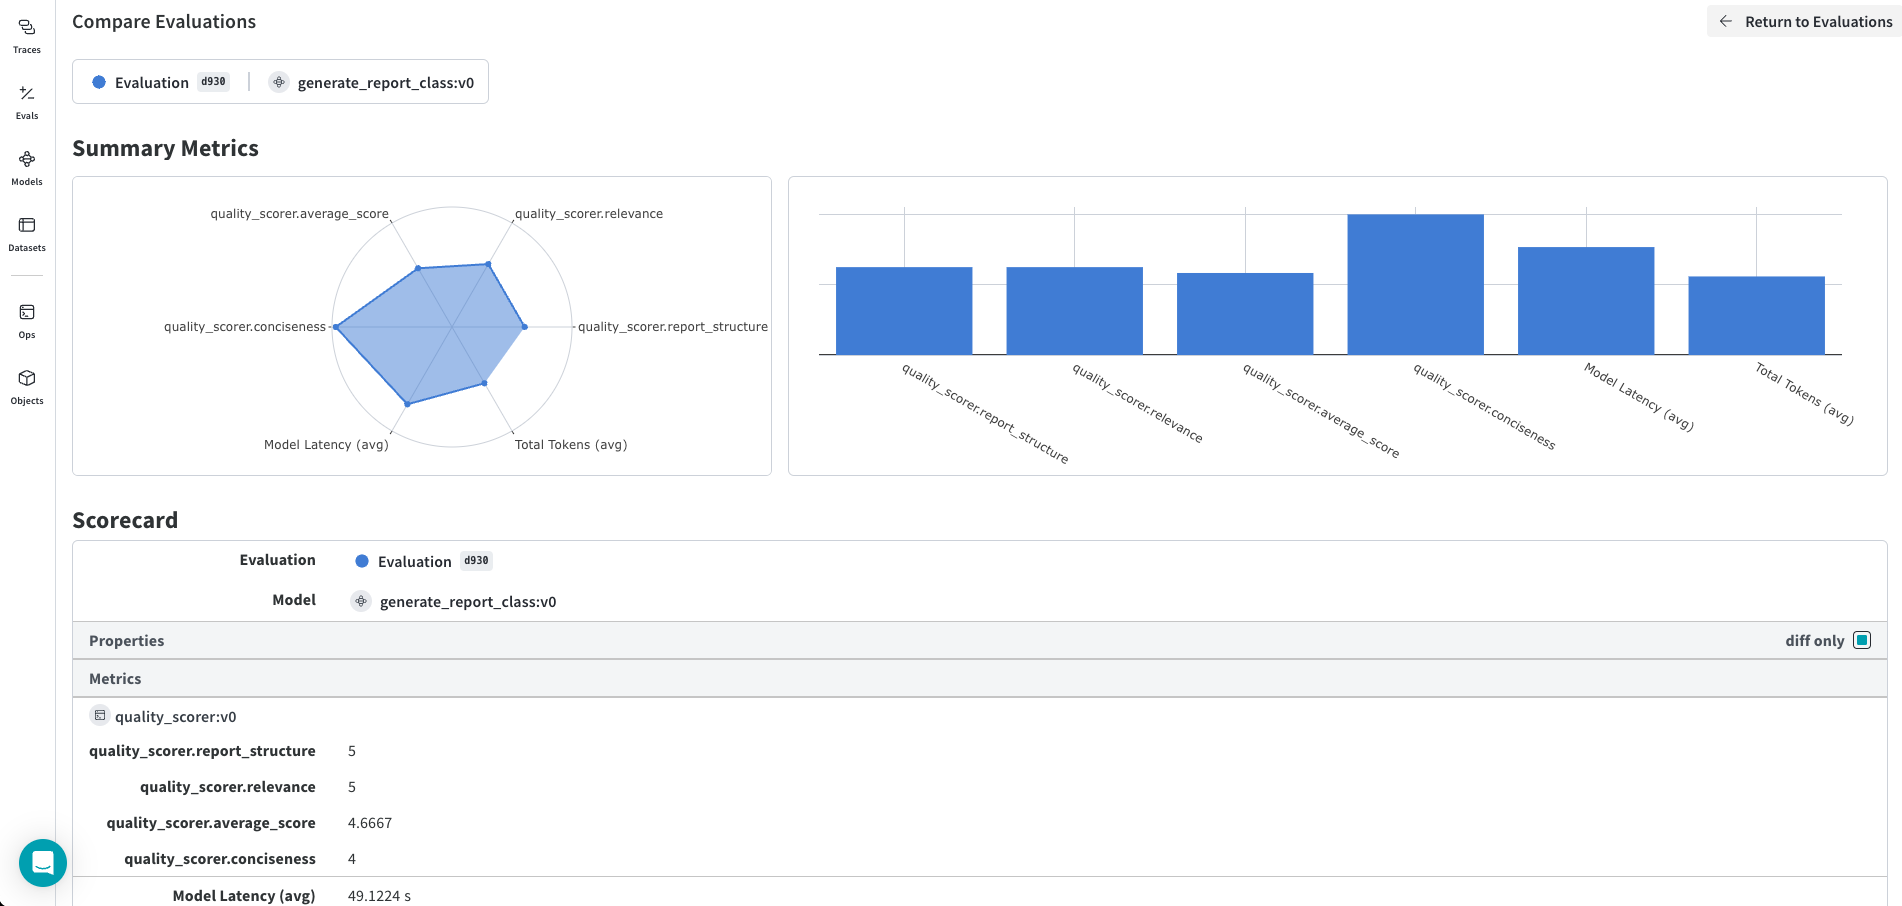


# Conclusion

In this example, we have demonstrated the development of an AI research assistant pipeline, using Weave for logging and evaluation and a search API for web data retrieval. The key steps included:

- Breaking down the main topic into **subtopics** for focused and targeted search queries.
- Using a **search API** (like Tavily or alternatives) to retrieve relevant web content.
- **Cleaning and chunking** the data to ensure structured and processable input.
- Indexing the processed data into a **vector database** for efficient semantic search.
- Employing a **similarity post-processor** to filter search results based on relevance.
- Creating a full **context** for the LLM by compiling the most relevant information from each subtopic.
- Running the **LLM processing** step to synthesize the context into a coherent and insightful output.
- Using **Weave for logging and evaluation**, enabling traceability, debugging, and performance tracking of the AI assistant pipeline.

This structured approach ensures efficient retrieval of relevant information and the generation of well-informed responses by the LLM. Weave’s comprehensive logging capabilities also make the workflow easily reproducible and evaluable. Moving forward, this framework can be extended by integrating additional APIs, databases, or advanced LLM models for more robust performance.

